# American Express - Clients Default

## 0. Understanding the problem  

The objective of this notebook is to create a model to predict the probability that a client incurs in default (that is, that the customer does not pay back the credit card balance amount) using certain data obtained for each client during a period of 18 months. To determine the value of the target variable (Pay due amount = 0, Default = 1), it has been considered a default event when the client does not pay due amount in the next 120 days. 

The data used for this project has been obtained from an official competition carried out on Kaggle's website. This data has been previously anonymized, so it is not possible to interprete the information. However, even though almost all columns are numerical, the data provider has indicated which of the columns should be treated as categoricals from the beggining.

The original competition included two csv files: One for the train data and another for the test data. As only the train dataset has the solution for the target variable, this project will focus on this file. 

The train dataset contains by itself 458,913 rows. This size will allow us to separate it in a train and test dataset to obtain realiable results.

## 1. Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import classification_report

import joblib

## 2. Loading the dataset and performing minor adjustments

The dataset will be loaded using two Panda's Dataframes, as the main data is included in the file "train_data", while the values for the target are included in the file "train_labels". Then, both Dataframes will be merged and the original ones will be deleted to save space in Memory.

At the end of this chapter, some columns will be transformed into categories as indicated by the data provider. The columns customer_id and S_2 (dates of the transactions) will be deleted, as they have a 100% cardinality and seem to be useless for the model.

**Note 1: The train dataset has a size of 15.2GB and it is not possible to upload it to GitHub. It can be found in this link below:**

https://www.kaggle.com/competitions/amex-default-prediction/data?select=train_data.csv

**Note 2: The model obtained and exported at the end of this notebook has a size of more than 7GB. For this reason, it cannot be uploaded to GitHub. It has been provided in the same folder than the presentation video in Google Drive**

In [2]:
train_data = pd.read_csv("../data/train_data.csv", nrows= 458913)
train_data_labels = pd.read_csv("../data/train_labels.csv", nrows = 458913)

In [3]:
train_data_labels.head(10)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
5,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0
6,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0
7,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,0
8,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,1
9,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,1


In [4]:
train_data.head(10)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,0.009857,0.009866,...,NaN,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0.002183,0.018859,1.008024,0.004509,0.103329,0.006603,0.000783,...,NaN,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0.003029,0.014324,1.000242,0.000263,0.108115,0.009527,0.007836,...,NaN,NaN,NaN,0.002397,0.008452,0.005553,NaN,0.001831,0.009616,0.007385
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0.009896,0.016888,1.003995,0.001789,0.102792,0.002519,0.009817,...,NaN,NaN,NaN,0.009742,0.003968,0.007945,NaN,0.008722,0.004369,0.000995
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0.001082,0.001930,1.007504,0.001772,0.100470,0.004626,0.006073,...,NaN,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068


In [5]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,455178.0,0.654854,0.245972,-3.830190e-01,0.477599,0.692703,0.864817,1.010000
D_39,458913.0,0.152878,0.269159,4.574952e-08,0.004529,0.009057,0.236223,5.331360
B_1,458913.0,0.125290,0.213332,-8.993963e-01,0.008855,0.031631,0.128913,1.324053
B_2,458742.0,0.619381,0.401789,1.562542e-06,0.103133,0.814250,1.002333,1.010000
R_1,458913.0,0.079145,0.226183,2.962930e-08,0.002902,0.005788,0.008664,3.000852
...,...,...,...,...,...,...,...,...
D_141,450754.0,0.166567,0.350250,2.320579e-08,0.003038,0.006072,0.009109,1.253571
D_142,79329.0,0.392557,0.239212,-1.444070e-02,0.197994,0.383925,0.563317,1.840632
D_143,450754.0,0.180930,0.380764,1.653580e-08,0.003044,0.006077,0.009101,1.010000
D_144,455590.0,0.054434,0.187935,4.712723e-08,0.002754,0.005517,0.008273,1.343316


In [6]:
train_data = pd.merge (left = train_data, right = train_data_labels, on="customer_ID")

del train_data_labels

In [7]:
train_data.head(10)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,0.009857,0.009866,...,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0.002183,0.018859,1.008024,0.004509,0.103329,0.006603,0.000783,...,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0.003029,0.014324,1.000242,0.000263,0.108115,0.009527,0.007836,...,NaN,NaN,0.002397,0.008452,0.005553,NaN,0.001831,0.009616,0.007385,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0.009896,0.016888,1.003995,0.001789,0.102792,0.002519,0.009817,...,NaN,NaN,0.009742,0.003968,0.007945,NaN,0.008722,0.004369,0.000995,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0.001082,0.001930,1.007504,0.001772,0.100470,0.004626,0.006073,...,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068,0


In [8]:
# We will drop the customer_ID and S_2 columns, as they are not relevant for the model:
train_data = train_data.drop(["customer_ID", "S_2"], axis = 1)

In [9]:
# We will convert these variables to categorical, as it is indicated in the Kaggle dataset description:
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

train_data[categorical_variables] = train_data[categorical_variables].astype("category")

In [10]:
train_data[categorical_variables]

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,6.0
...,...,...,...,...,...,...,...,...,...,...
458908,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,6.0
458909,0.0,1.0,1.0,0.0,-1.0,0.0,1.0,CO,R,6.0
458910,1.0,5.0,1.0,0.0,3.0,0.0,1.0,CO,O,4.0
458911,0.0,5.0,1.0,0.0,3.0,0.0,1.0,CO,O,4.0


## 3. NA management.
   
Given the size of the dataset, the first thing to be made is to drop those columns which % of NA is above the 30%. We can follow this procedure only because we're dealing with a large dataset. This will also help to reduce the number of columns, reducing the time needed to train the models. Trying to impute a higher percentage of values with the method used herebelow in this chapter could result in unprecise results, reducing the accuracy of the dataset.

<Axes: >

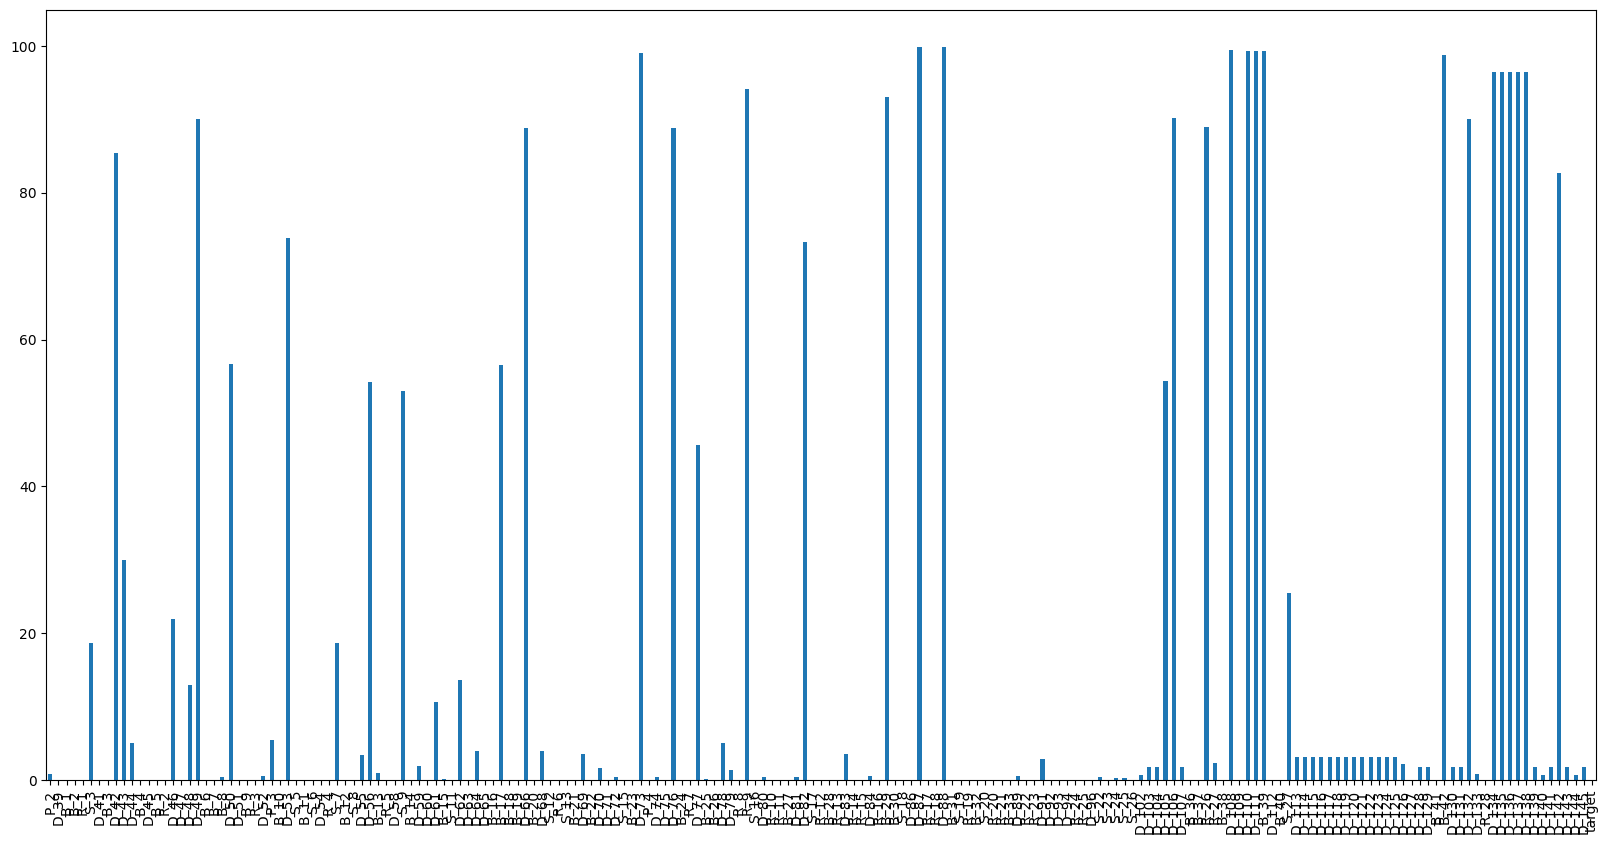

In [11]:
# We will take a look at the % of nulls in the dataset for each variable:
(train_data.isnull().sum()/(len(train_data))*100).plot(figsize = (20,10), kind = "bar")

In [12]:
# We will drop the variables with more than 35% of nulls:
for index, nan_perc in zip((train_data.isnull().sum()/(len(train_data))*100).index, (train_data.isnull().sum()/(len(train_data))*100).values):
    if nan_perc >= 35:
        train_data = train_data.drop(index, axis = 1)

<Axes: >

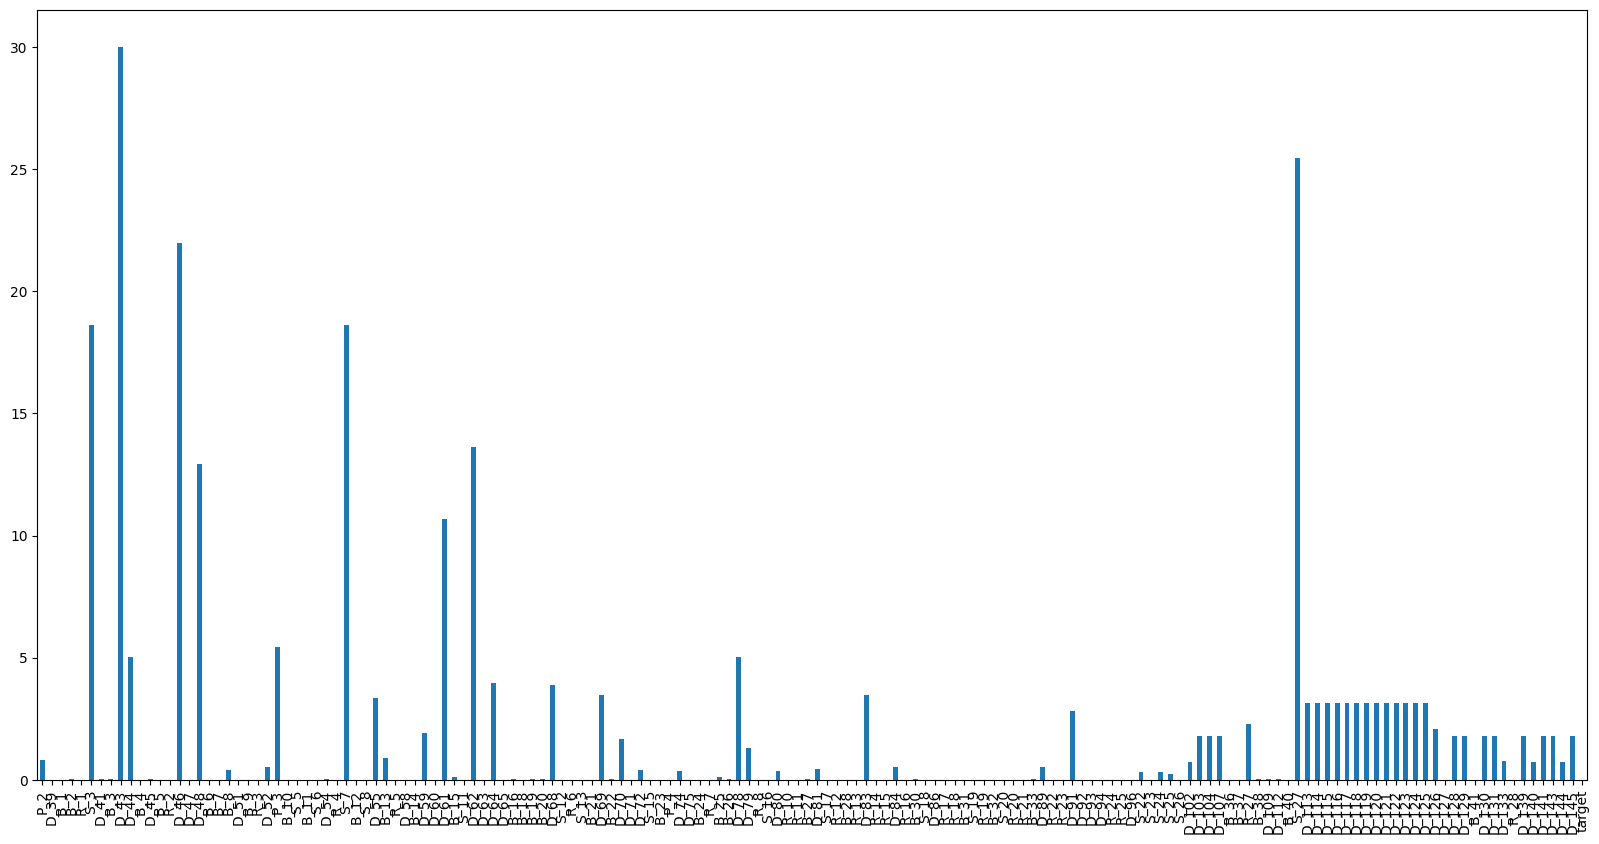

In [13]:
(train_data.isnull().sum()/(len(train_data))*100).plot(figsize = (20,10), kind = "bar")

Instead of eliminating the null values for the remaining columns or imputing them using the mean or the median, we'll proceed using a simple XGBoost model to impute them. To do so, the data of the other columns will be used to estimate the null values. XGBoost has been the model selected due to its capacity to handle null values.

First, XGBoost Regressor will be used to impute the numerical values. Then, XGboost Classifier will be used for the categorical columns

In [ ]:
# Iterating over each column with missing values
for column in train_data.columns:
    if train_data[column].isnull().sum() > 0 and train_data[column].dtype != 'category':
                # Data is divided into two sets: one with non-null values and another with null values
        df_not_null = train_data[train_data[column].notnull()]
        df_null = train_data[train_data[column].isnull()]
        
         # The caracteristics and the target variable are separated
        X = df_not_null.drop(columns=[column]).iloc[0:250000,:] # Due to RAM memory constraints, only the first 250000 rows are selected
        y = df_not_null[column].iloc[0:250000]
        
        
        # Only the numeric columns are selected for this first model
        X = X.select_dtypes(include=[np.number])
        X_null = df_null.drop(columns=[column]).select_dtypes(include=[np.number])
        
        # Create the model
        model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, 
                                     enable_categorical=True, n_jobs = -1)
       
        model.fit(X, y)

        # Predict the missing values
        y_pred = model.predict(X_null)
        
        # Fill the missing values using the predicted values
        train_data.loc[train_data[column].isnull(), column] = y_pred

In [15]:
# Delete the variables used in the model to free up memory
del X, y, X_null, y_pred, df_not_null, df_null, model

In [16]:


# Convert categorical columns to numerical using LabelEncoder
label_encoders = {}
for column in categorical_variables:
    label_encoders[column] = LabelEncoder()
    train_data[column] = label_encoders[column].fit_transform(train_data[column].astype(str))

# Impute missing values for categorical columns
for column in categorical_variables:
    if train_data[column].isnull().sum() > 0:
        # Split the data into two sets: one with non-null values and one with null values
        df_not_null = train_data[train_data[column].notnull()]
        df_null = train_data[train_data[column].isnull()]
        
        # Separate features and target variable
        X = df_not_null.drop(columns=[column]).iloc[0:250000,:]
        y = df_not_null[column].iloc[0:250000,:]
        
        # Filter only numerical columns
        X = X.select_dtypes(include=[np.number])
        X_null = df_null.drop(columns=[column]).select_dtypes(include=[np.number])
        
        # Create and train the XGBoost model
        model = xgboost.XGBClassifier(objective='multi:softmax', n_estimators=100, max_depth=6, learning_rate=0.1)
        model.fit(X, y)
        
        # Predict the missing values
        y_pred = model.predict(X_null)
        
        # Fill the missing values with the predictions
        train_data.loc[train_data[column].isnull(), column] = y_pred

# Convert the columns back to their original categories
for column in categorical_variables:
    train_data[column] = label_encoders[column].inverse_transform(train_data[column].astype(int))

In [17]:
# Delete the variables used in the model to free up memory

variables_to_delete = ['X', 'y', 'X_null', 'y_pred', 'df_not_null', 'df_null', 'model', 'label_encoders']
for var in variables_to_delete:
    if var in globals():
        del globals()[var]

In [18]:
# Checking if there are any missing values left
train_data.isnull().sum().sum()

0

In [19]:
train_data.head(5)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,0.042689,0.000630,...,0.005972,0.004345,0.001535,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674,0
1,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,0.044310,0.002526,...,0.004838,0.007495,0.004931,0.003954,0.003167,0.005032,0.009576,0.005492,0.009217,0
2,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,0.042128,0.007605,...,0.005497,0.009227,0.009123,0.003269,0.007329,0.000427,0.003429,0.006986,0.002603,0
3,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,0.043507,0.006406,...,0.008261,0.007206,0.002409,0.006117,0.004516,0.003200,0.008419,0.006527,0.009600,0
4,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,0.056638,0.007731,...,0.004848,0.006312,0.004462,0.003671,0.004946,0.008889,0.001670,0.008126,0.009827,0


## 4. Correlation between variables

We will proceed to see, on one hand, the correlation of the dependent variable with the independent ones and, on the other hand, the correlation among the independent variables themselves. Based on this, we aim to eliminate those variables that do not have a relationship with the dependent variable and those independent variables that have a high correlation among themselves.

In [20]:
# The thresholds for the correlation analysis are defined as follows:

threshold_min_corr_with_dependent = 0.1
threshold_max_corr_between_independent = 0.8

In [21]:
# We will study the correlation between the numerical variables. We will drop the categorical variables for this analysis:

dataset_without_categorical = train_data.drop(categorical_variables, axis = 1)

In [22]:
for variable, corr in zip(dataset_without_categorical.corr()["target"].abs().index, dataset_without_categorical.corr()["target"].abs().values):
    if (corr < threshold_min_corr_with_dependent)&(variable!="target"):
        train_data = train_data.drop([variable], axis = 1)

In [23]:
independent_variables_to_drop = []
dataset_without_categorical = train_data.drop(categorical_variables, axis = 1)
dataset_without_categorical = dataset_without_categorical.drop("target", axis = 1)
dataset_without_categorical_corr = dataset_without_categorical.corr()

for i in (dataset_without_categorical_corr):
    for variable, corr in zip(dataset_without_categorical_corr[i].abs().index, dataset_without_categorical_corr[i].abs().values):
        if (corr > threshold_max_corr_between_independent)&(variable!=i):
            independent_variables_to_drop.append(variable)

set(independent_variables_to_drop)

del dataset_without_categorical

In [24]:
train_data = train_data.drop(independent_variables_to_drop, axis = 1)

In [25]:
train_data.head()

,P_2,D_39,R_1,D_41,B_3,D_43,D_44,B_4,D_45,R_2,...,D_122,D_126,D_127,D_128,D_129,D_130,D_133,D_140,D_145,target
0,0.938469,0.001733,0.009228,0.008771,0.004709,0.042689,0.000630,0.080986,0.708906,0.006204,...,0.434345,1.0,1.003319,1.007819,1.000080,0.002052,0.004345,0.003706,0.002674,0
1,0.936665,0.005775,0.006151,0.000798,0.002714,0.044310,0.002526,0.069419,0.712795,0.006206,...,0.430501,1.0,1.008394,1.004333,1.008344,0.001034,0.007495,0.003167,0.009217,0
2,0.954180,0.091505,0.006815,0.007598,0.009423,0.042128,0.007605,0.068839,0.720884,0.003259,...,0.434409,1.0,1.009307,1.007831,1.006878,0.005681,0.009227,0.007329,0.002603,0
3,0.960384,0.002455,0.001373,0.000685,0.005531,0.043507,0.006406,0.055630,0.723997,0.009918,...,0.436903,1.0,1.001671,1.003460,1.007573,0.007108,0.007206,0.004516,0.009600,0
4,0.947248,0.002483,0.007605,0.004653,0.009312,0.056638,0.007731,0.038862,0.720619,0.006667,...,0.437433,1.0,1.009886,1.005053,1.008132,0.009680,0.006312,0.004946,0.009827,0


<Axes: >

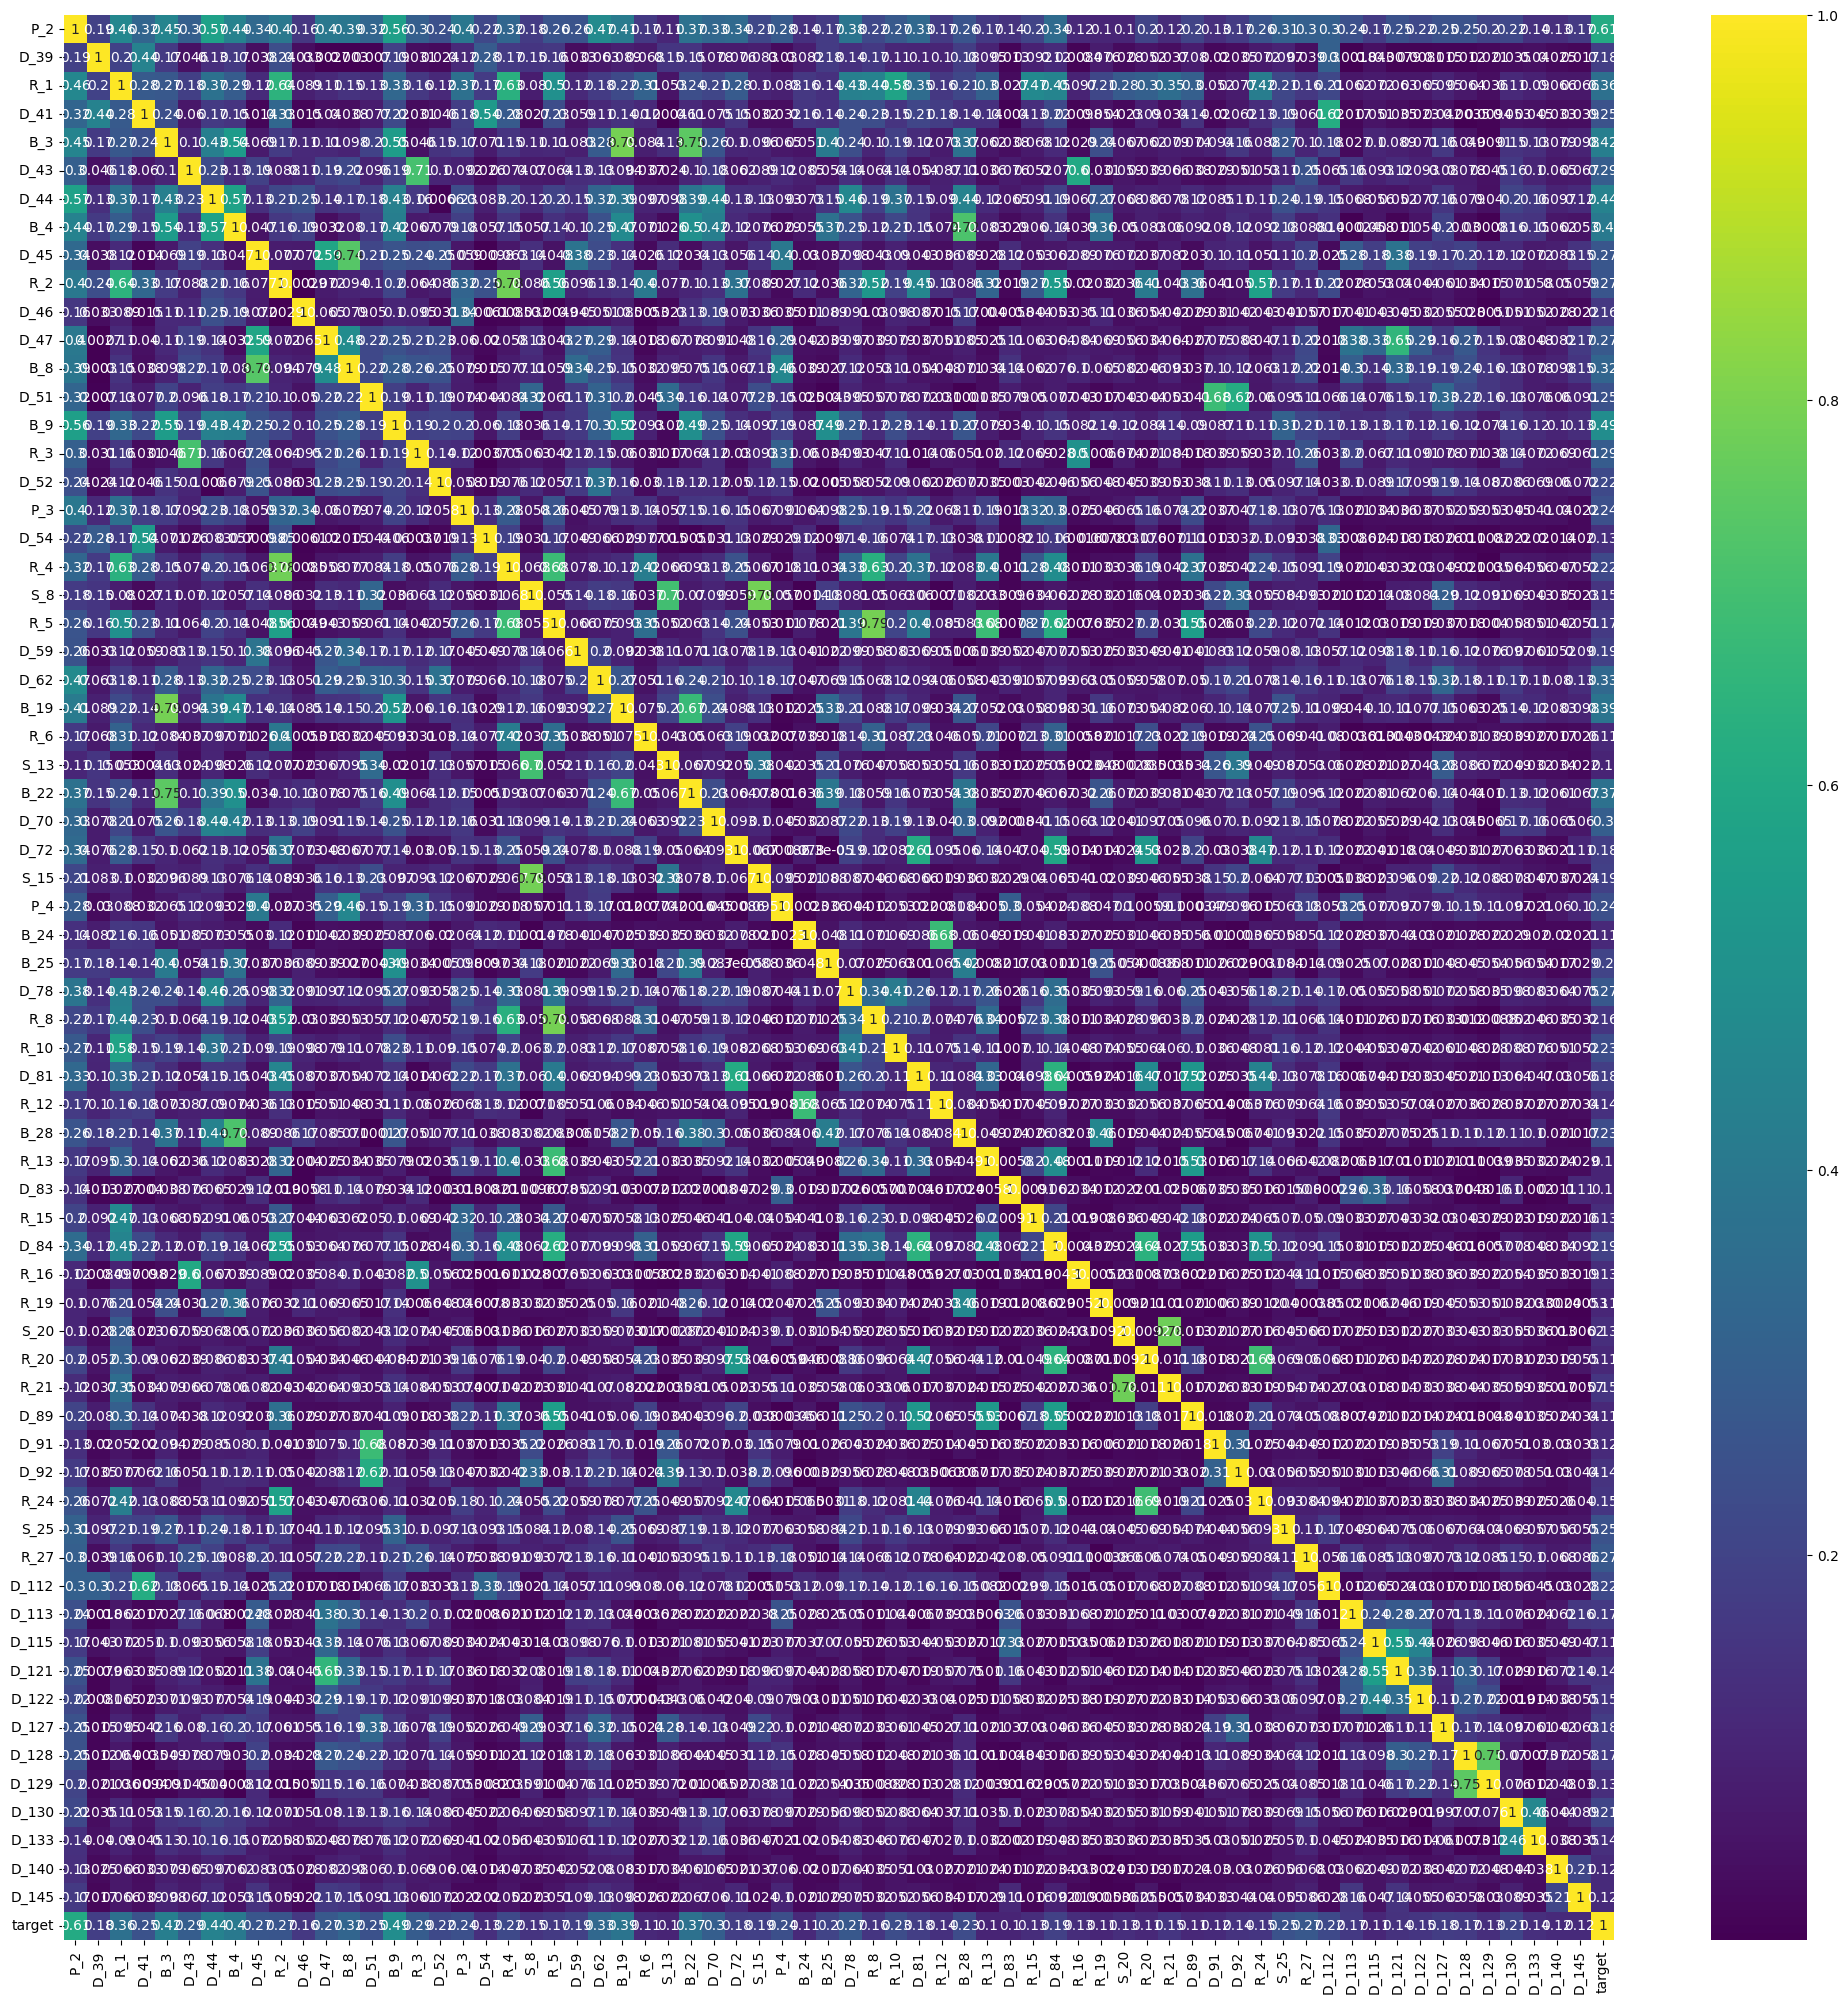

In [26]:
plt.figure(figsize = (25,25))
sns.heatmap(data = train_data.select_dtypes(include = "number").corr().abs(), cmap = "viridis", annot=True)

## 5. Outliers

As we're dealing with a classification problem, it'd be better to keep the outliers. Detecting data that follows patterns different others than the general rules could gives us a clue to detecting cases of default


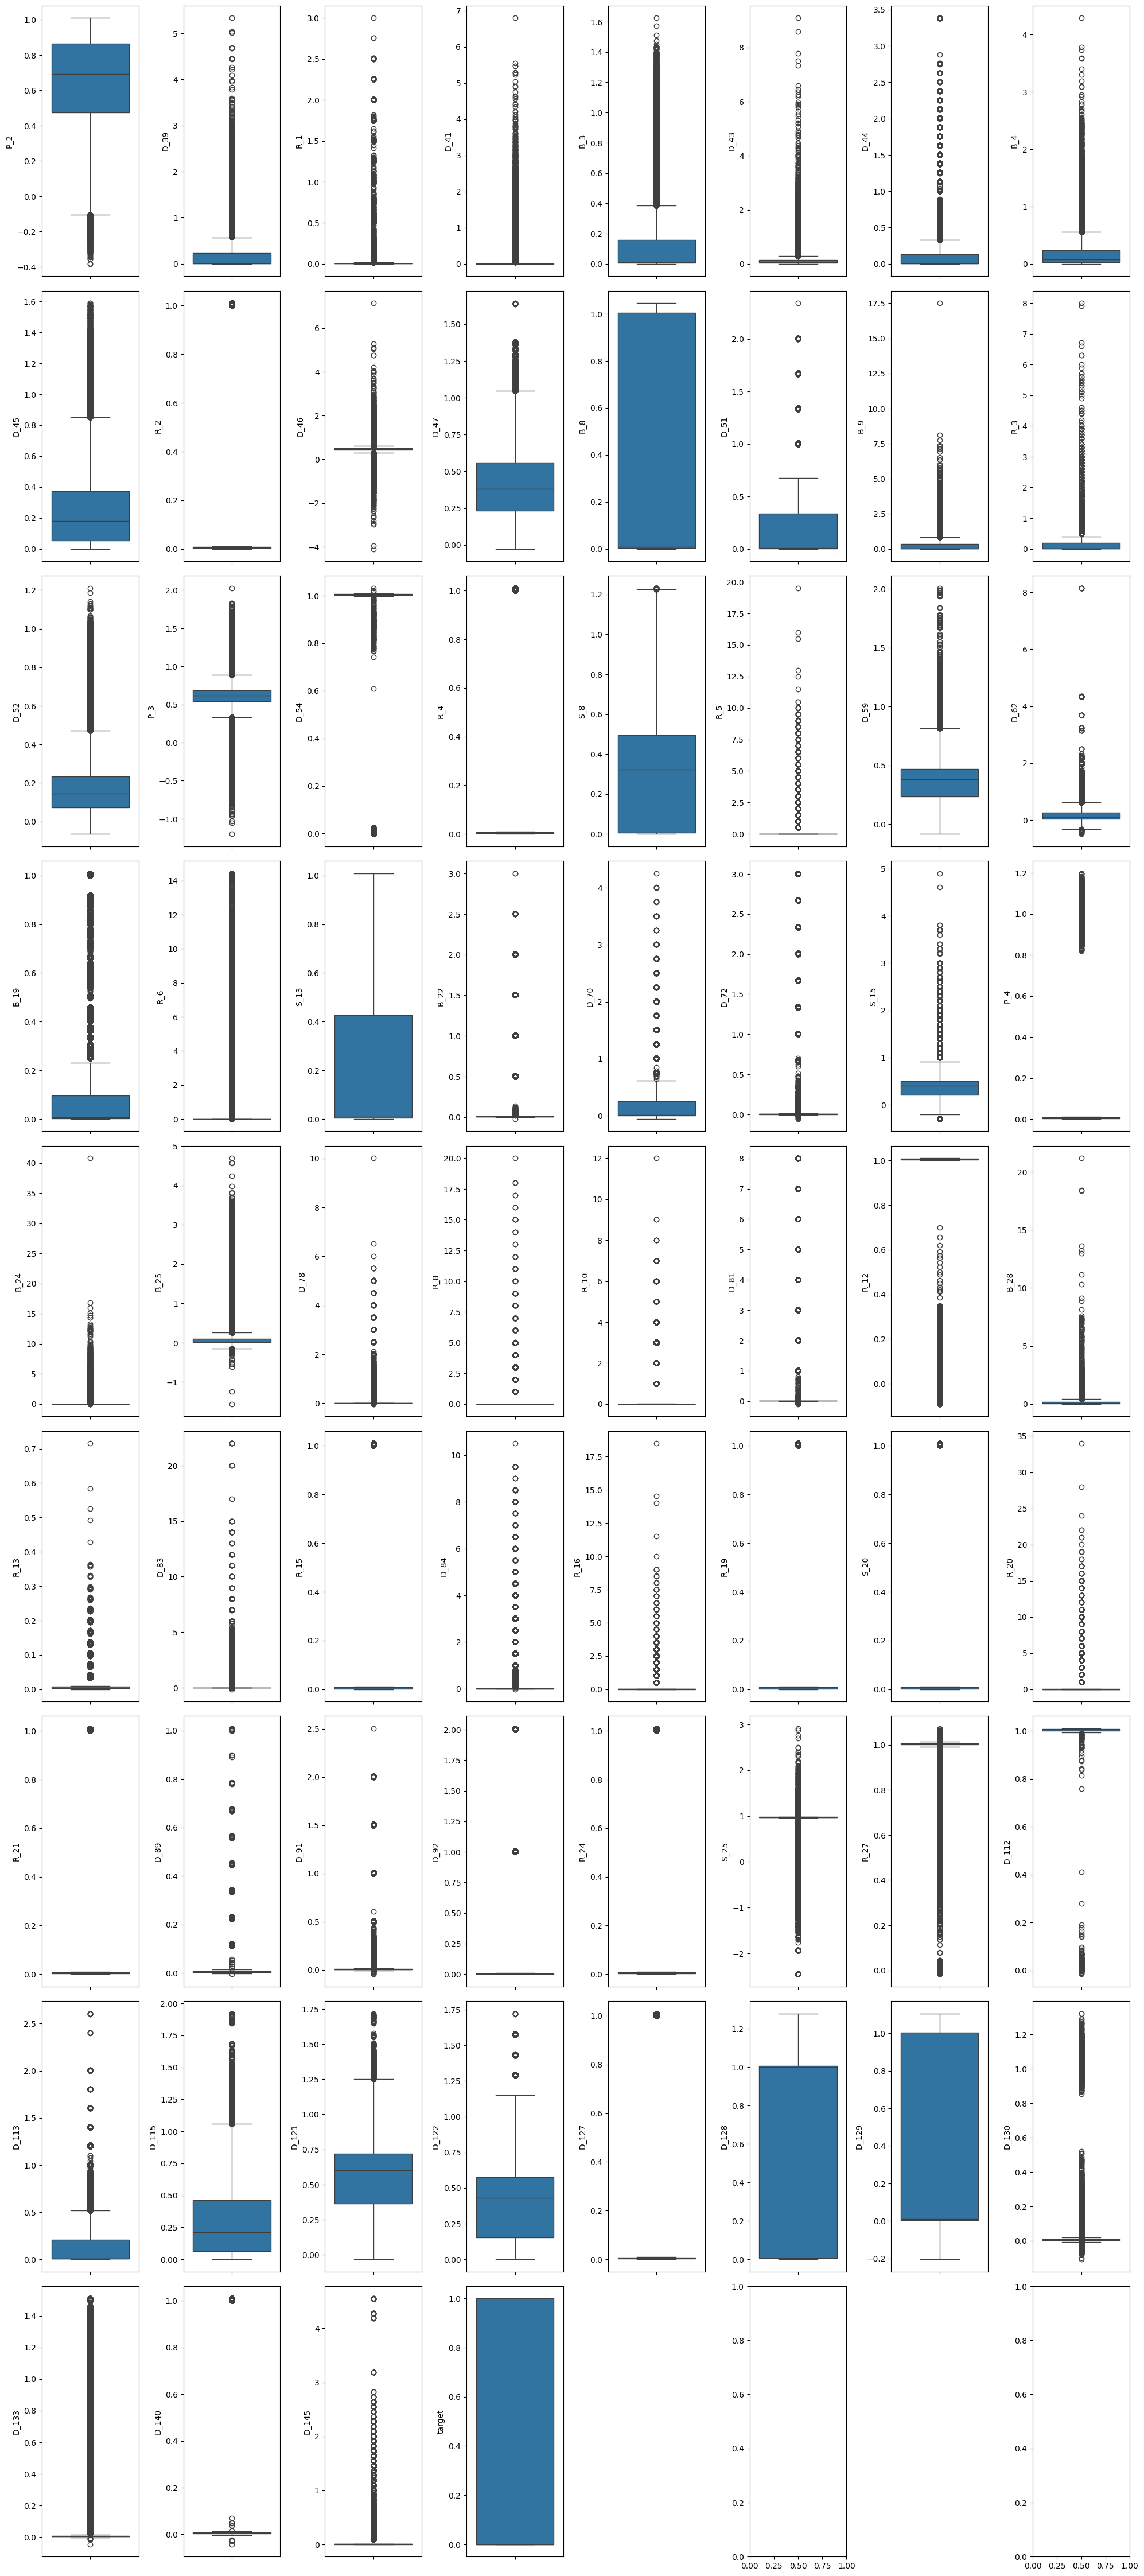

In [27]:
num_columns = 8
num_rows = (len(train_data.drop(categorical_variables, axis=1).columns) + num_columns - 1) // num_columns

fig, ax = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))

for i, axis in zip(train_data.drop(categorical_variables, axis=1).columns, fig.axes):
    sns.boxplot(data=train_data, y=i, ax=axis)

# Remove any extra axes
for j in range(len(train_data.drop(categorical_variables, axis=1).columns), num_rows * num_columns):
    if j < len(fig.axes):
        fig.axes[j].remove()

plt.tight_layout()
plt.show()

## 6. Cardinality
Variables with a cardinality less than 10% will be converted to categorical

In [28]:
# Calculate the cardinality proportion for each column
cardinality = train_data.nunique() / len(train_data) * 100

# Identify variables with cardinality less than 10%
low_cardinality_columns = cardinality[cardinality < 10].index.tolist()

# Convert these variables to categorical
for col in low_cardinality_columns:
    train_data[col] = train_data[col].astype('category')

## 7. Categorical variables analysis
In this chapter an EDA of the categorical variables will be performed

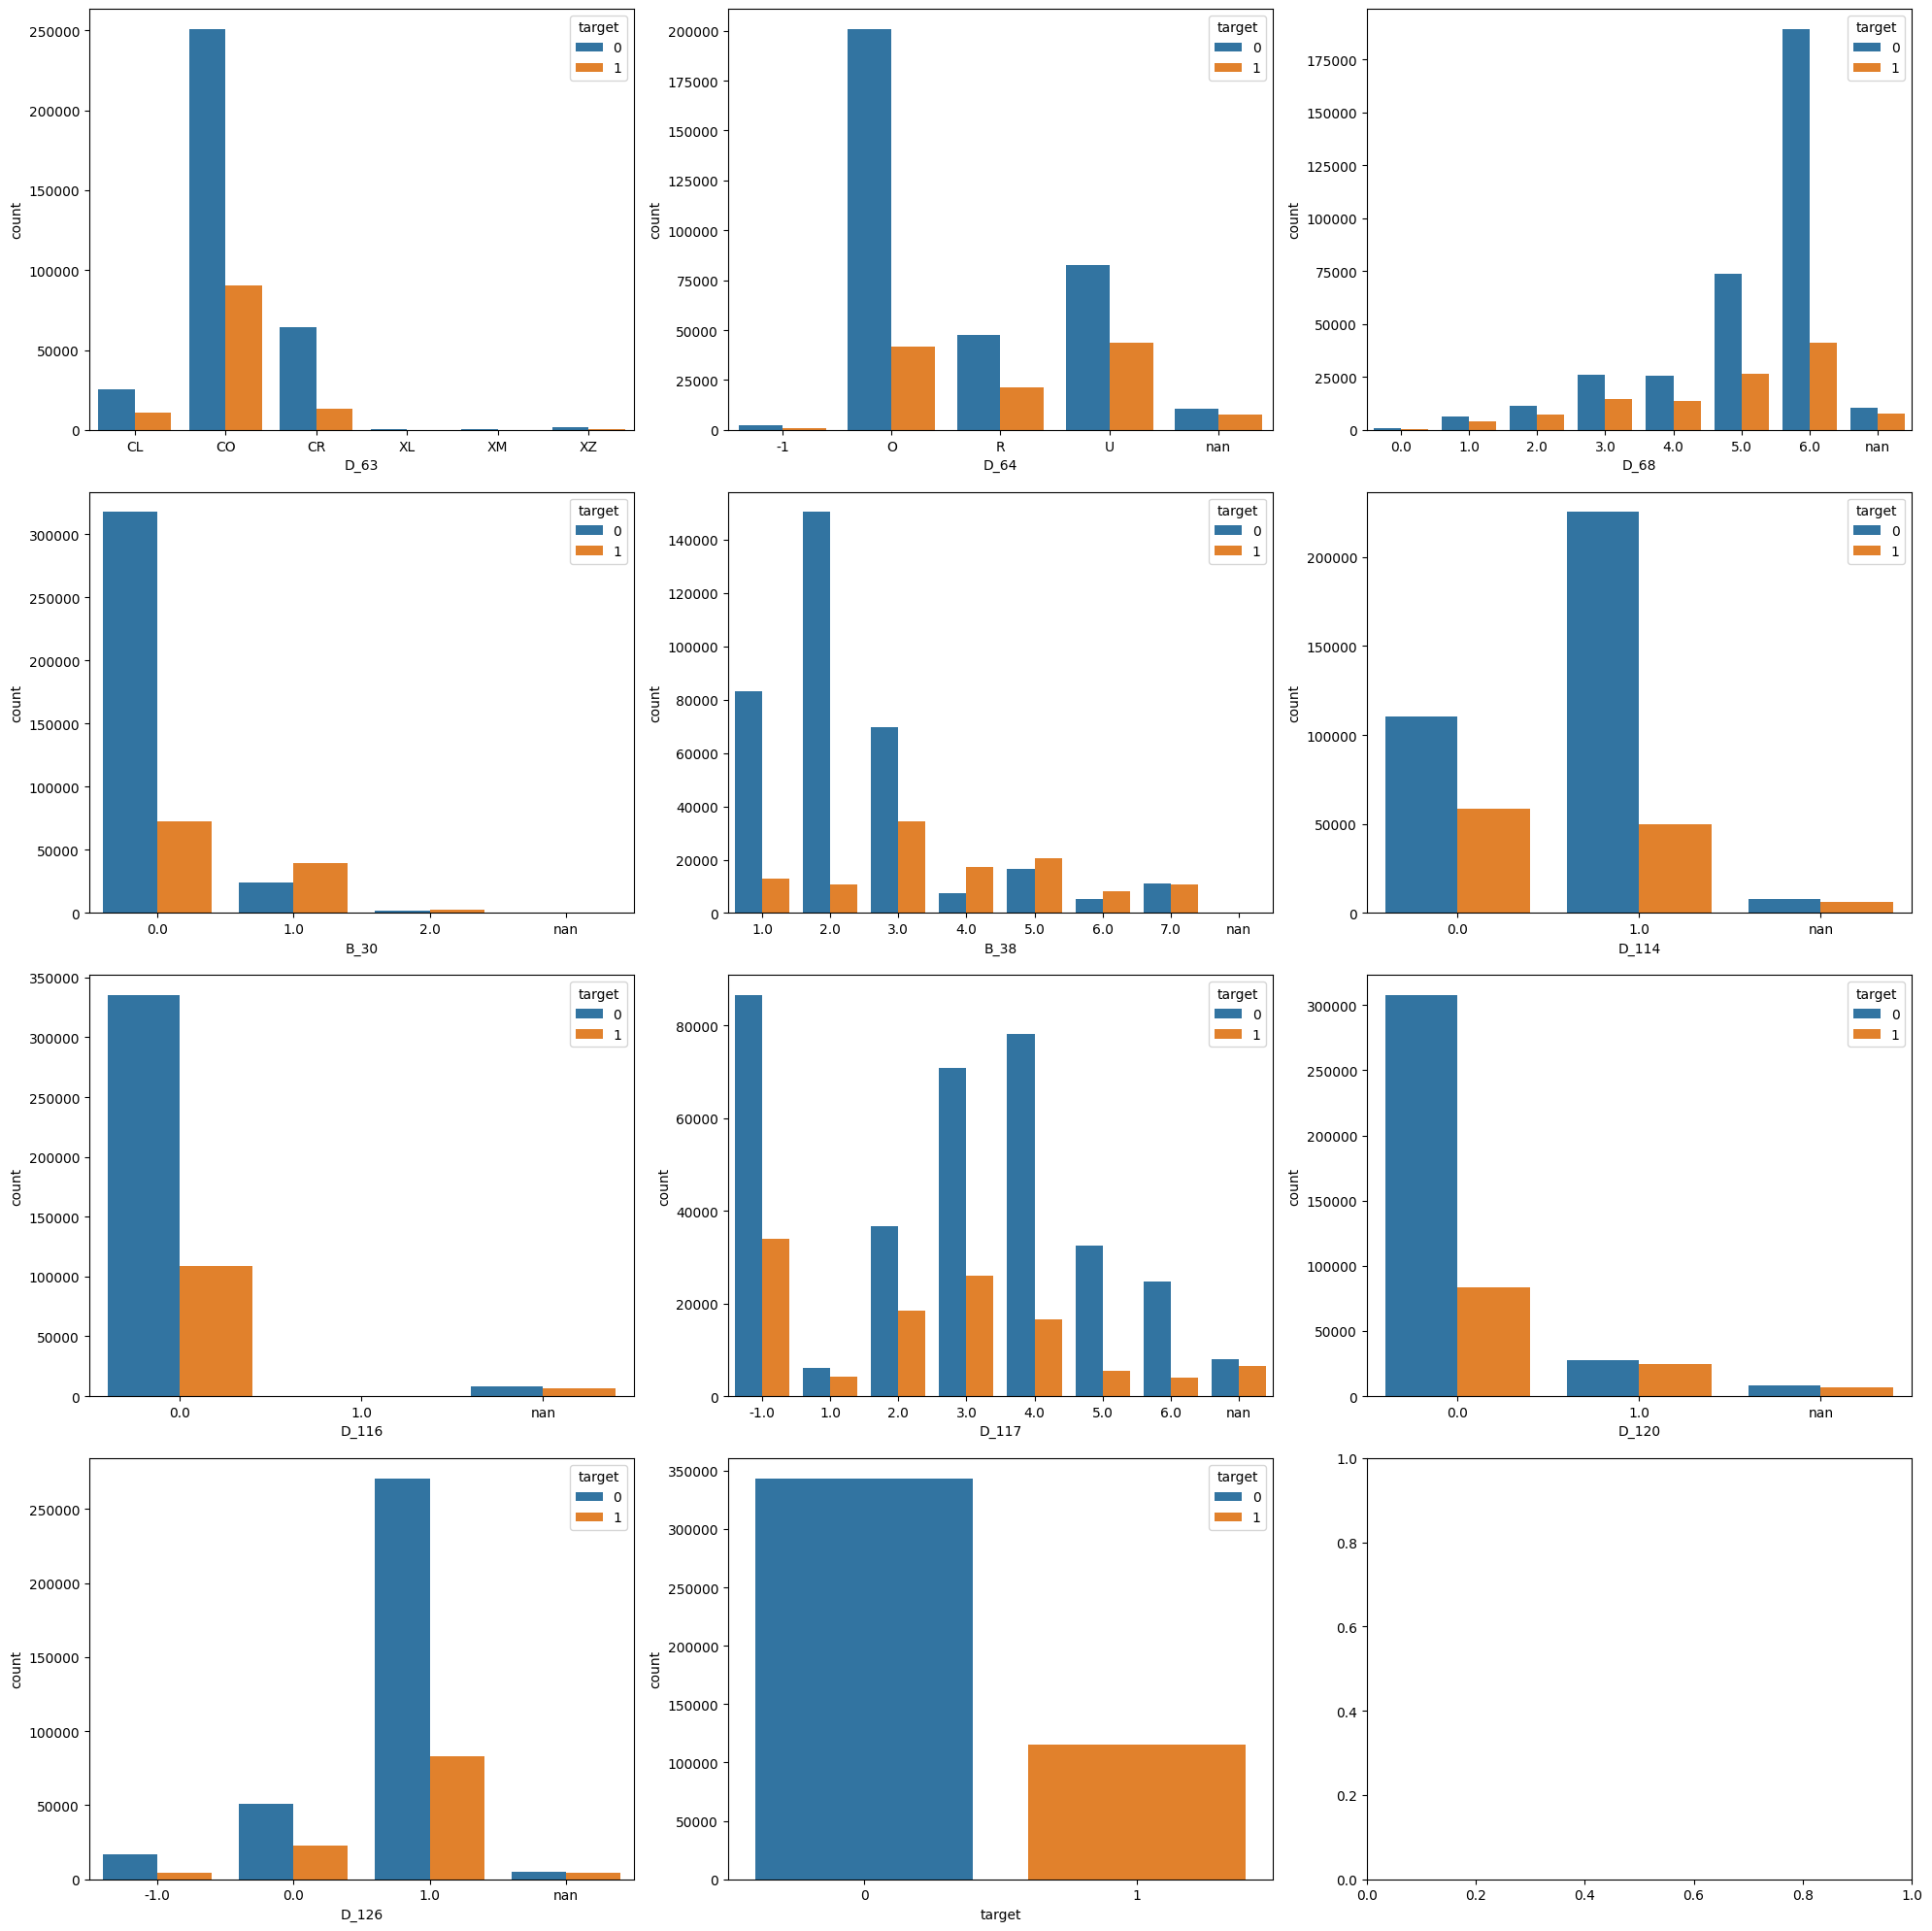

In [29]:
categorical_variables = train_data.select_dtypes(include = "category").columns


fig, ax = plt.subplots(len(categorical_variables) // 3 + 1, 3, figsize=(20, 5 * (len(categorical_variables) // 3 + 1)))
for cat, ax in zip(categorical_variables, fig.axes):
    sns.countplot(data=train_data, x=cat, ax=ax, hue = "target")
plt.tight_layout()
plt.show()

<Axes: xlabel='target', ylabel='count'>

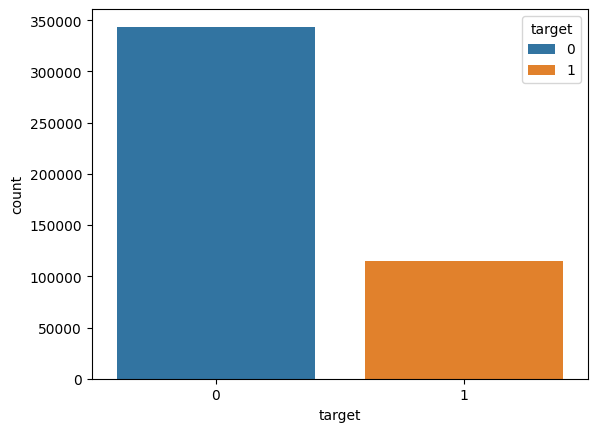

In [30]:
sns.countplot(data=train_data, x="target", hue = "target")

In general, target = 1 is represented in all categories similarly to the proportion with respect to target = 0. This underrepresentation should be taken into account when creating the models.

### 7.1 Correlation Tests Between Categorical Variables

We will perform correlation tests between categorical variables and eliminate those that have a high correlation with each other.

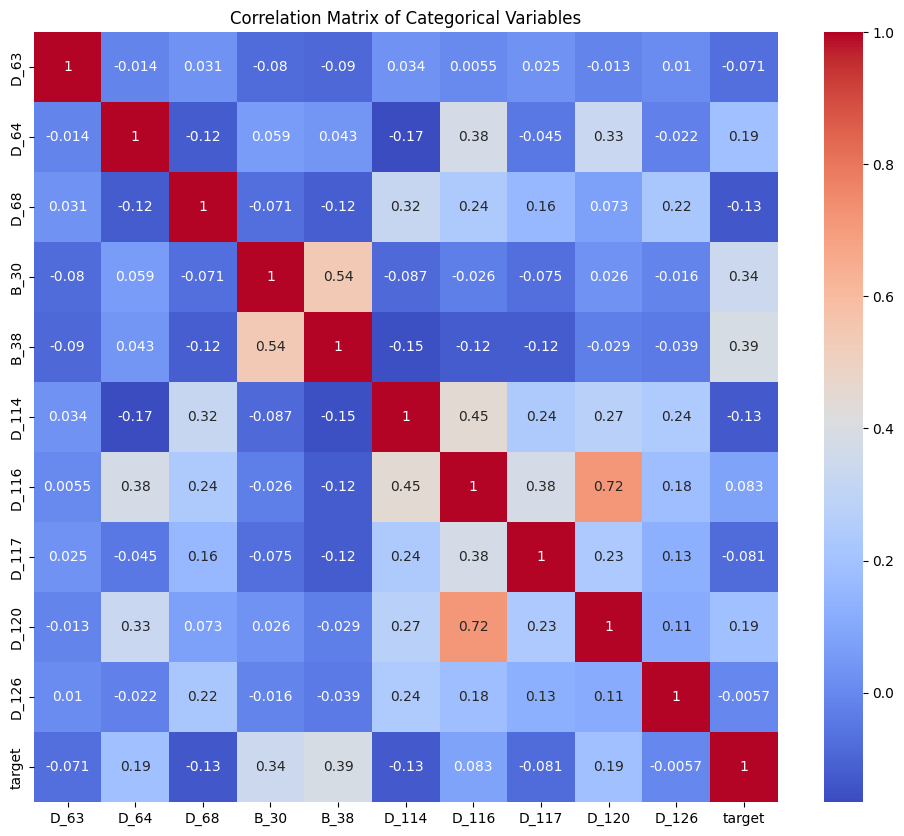

In [31]:
# Calculate the correlation matrix for categorical variables
categorical_corr = train_data[categorical_variables].apply(lambda x: x.cat.codes).corr()

# Display the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Categorical Variables')
plt.show()

In [32]:
del categorical_corr

The correlation between the variables and the target is, in general, low. However, as the number of categorical values is not excessively large, they will be maintained and included in the model

## 8. One Hot Encoding

Pandas will be used to perform the One Hot Encoding of the categorical variables

In [33]:
categorical_variables = train_data.drop("target", axis = 1).select_dtypes(include = "category").columns

X = train_data.drop("target", axis = 1)
y = train_data["target"]

X = pd.get_dummies(X, columns = categorical_variables, drop_first=True)


## 9. Train-test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)

numerical_variables = X.select_dtypes(include = "number").columns


## 10. Data normalization

Due to the presence of outliers saw in a previous chapter, data shall be normalized to prevent that some variables adquire a higher weight in the model. Standard Scaler will be used in this case

In [35]:
standarizer = StandardScaler()
X_train[numerical_variables] = standarizer.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = standarizer.transform(X_test[numerical_variables])

In [36]:
del standarizer

## 11. Models

In this chapter, different models will be trained to predict the data. The optimized parameters have been obtained using GridSearchCV. However, this part of the code has been removed to reduce the amount of time required to run the entire notebook. At the end of the chapter, the different models will be combined using StackingClassifier.

Before starting, variables not required to train the models will be removed to free RAM memory

In [37]:
del X, y, train_data

### 11.1 Sklearn LogisticRegression

In [38]:
parameters = {"penalty" : ["l2"],
             "tol" : [0.0001],
             "C" : [0.1],
             "solver" : ["sag"],
             "n_jobs" : [-1],
             "max_iter" : [2000]}

logistic_reg = LogisticRegression()

grid = GridSearchCV(estimator=logistic_reg, param_grid=parameters)
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1], 'max_iter': [2000], 'n_jobs': [-1],
                         'penalty': ['l2'], 'solver': ['sag'],
                         'tol': [0.0001]})

In [39]:
grid.best_score_

0.8671923366312863

In [40]:
grid.best_params_

{'C': 0.1,
 'max_iter': 2000,
 'n_jobs': -1,
 'penalty': 'l2',
 'solver': 'sag',
 'tol': 0.0001}

In [41]:
logistic_reg = grid.best_estimator_

In [42]:
logistic_reg_pred = logistic_reg.predict(X_test)

In [43]:
print(classification_report(y_test, logistic_reg_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91    103085
           1       0.75      0.70      0.72     34589

    accuracy                           0.87    137674
   macro avg       0.83      0.81      0.82    137674
weighted avg       0.86      0.87      0.87    137674



In [44]:
del logistic_reg_pred

### 11.2 Random Forest

In [45]:
parameters = {"n_estimators" : [1000],
             "criterion" : ["gini"],
             "min_samples_split" : [2],
             "min_samples_leaf" : [1],
              "min_weight_fraction_leaf" : [0.0],
             "n_jobs" : [-1],
            }

rand_forest = RandomForestClassifier()

grid = GridSearchCV(estimator = rand_forest, param_grid=parameters)

In [46]:
grid.fit(X_train,y_train)
grid.best_score_

0.9000401541641592

In [47]:
grid.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1}

In [48]:
rand_forest = grid.best_estimator_

In [49]:
rand_forest_pred = rand_forest.predict(X_test)

In [50]:
print(classification_report(y_test, rand_forest_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94    103085
           1       0.82      0.80      0.81     34589

    accuracy                           0.90    137674
   macro avg       0.87      0.87      0.87    137674
weighted avg       0.90      0.90      0.90    137674



In [51]:
del rand_forest_pred

### 11.3. KNeighborsClassifier

In [52]:
parameters = {"n_neighbors" : [3],
             #"criterion" : ["uniform", "distance"],
             "algorithm" : ["ball_tree"],
             #"leaf_size" : [30],
              "p" : [1],
             "n_jobs" : [-1],
            }

k_neigh = KNeighborsClassifier()

grid = GridSearchCV(estimator = k_neigh, param_grid=parameters)

In [53]:
grid.fit(X_train,y_train)
grid.best_score_

0.9656828710874021

In [54]:
grid.best_params_

{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1}

In [55]:
k_neigh = grid.best_estimator_

In [56]:
k_neigh_pred = k_neigh.predict(X_test)

In [57]:
print(classification_report(y_test, k_neigh_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98    103085
           1       0.96      0.93      0.95     34589

    accuracy                           0.97    137674
   macro avg       0.97      0.96      0.96    137674
weighted avg       0.97      0.97      0.97    137674



In [58]:
del k_neigh_pred

### 11.4. XGBoost

In [59]:
parameters = {"n_estimators" : [1500],
              "grow_policy": ["depthwise"],
              "max_depth" : [10],
              "learning_rate" : [0.2],
              "objective" : ["binary:logistic"],
              "sampling_method" :["uniform"],
              "gamma" : [0.01],
              "n_jobs" : [-1],
            }

xgb = xgboost.XGBClassifier(tree_method = "hist", device = "cuda")

grid = GridSearchCV(estimator = xgb, param_grid = parameters)

In [60]:
grid.fit(X_train,y_train)
print(grid.best_score_)

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.9378313302397558


In [61]:
grid.best_params_

{'gamma': 0.01,
 'grow_policy': 'depthwise',
 'learning_rate': 0.2,
 'max_depth': 10,
 'n_estimators': 1500,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'sampling_method': 'uniform'}

In [62]:
xgb = grid.best_estimator_

In [63]:
xgb_pred = xgb.predict(X_test)

In [64]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97    103085
           1       0.91      0.89      0.90     34589

    accuracy                           0.95    137674
   macro avg       0.93      0.93      0.93    137674
weighted avg       0.95      0.95      0.95    137674



In [65]:
del xgb_pred
del parameters
del grid

## 11.5. Combined Model   
Among the previous models, the one that achieved the best results in terms of precision and recall for the target class = 1 was KNeighbors. Nevertheless, we will create a final model combining all the previous ones.

In [66]:
stacked_model = StackingClassifier(estimators = [("lr",logistic_reg), ("rf",rand_forest),("kn",k_neigh),("xg",xgb)],
                                   n_jobs = -1, cv = 3)

stacked_model.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=2000,
                                                   n_jobs=-1, solver='sag')),
                               ('rf',
                                RandomForestClassifier(n_estimators=1000,
                                                       n_jobs=-1)),
                               ('kn',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     n_jobs=-1, n_neighbors=3,
                                                     p=1)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=No...
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.2, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1500, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   n_jobs=-1)

In [67]:
stacked_model_pred = stacked_model.predict(X_test)

In [68]:
print(classification_report(y_test, stacked_model_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    103085
           1       0.96      0.96      0.96     34589

    accuracy                           0.98    137674
   macro avg       0.97      0.97      0.97    137674
weighted avg       0.98      0.98      0.98    137674



In [69]:
del X_train
del y_train
del y_test
del X_test
del stacked_model_pred

The definitive combined model achieves better results than each of the indiviual models. The accuracy predicting the values of the test dataset is very high, being it close to 100%. The precision and recall for the target variable for the default case (target = 1) are very high as well, even considering that the positive value for the target variable was infrarrepresented.

## 12. Exporting the model

Finally, in this last step the model will be exported and saved in a separate folder. As the model has been created with scikit-learn, joblib will used for this purpose.

In [70]:
joblib.dump(stacked_model, '../models/stacked_model.pkl')

['../models/stacked_model.pkl']